In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table

Measurement = Base.classes.measurement
Station =Base.classes.station

In [8]:
inspector = inspect(engine)
columns_measurement = inspector.get_columns('Measurement')
for column in columns_measurement:
    print(column["name"], column["type"])

    
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)



# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
#recent_date = engine.execute('SELECT date FROM measurement ORDER BY date DESC').first().date
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

#dt.strptime
recent_date

'2017-08-23'

In [11]:
split_date = recent_date.split('-')
split_date

['2017', '08', '23']

In [12]:
type(recent_date)
#engine.execute('SELECT * FROM measurement ORDER BY date DESC').fetchall()

str

In [13]:
date_f = dt.datetime(int(split_date[0]),int(split_date[1]),int(split_date[2]))
date_f
date_i = dt.datetime(int(split_date[0])-1,int(split_date[1]),1)
date_i

datetime.datetime(2016, 8, 1, 0, 0)

Text(0, 0.5, 'Precipitation')

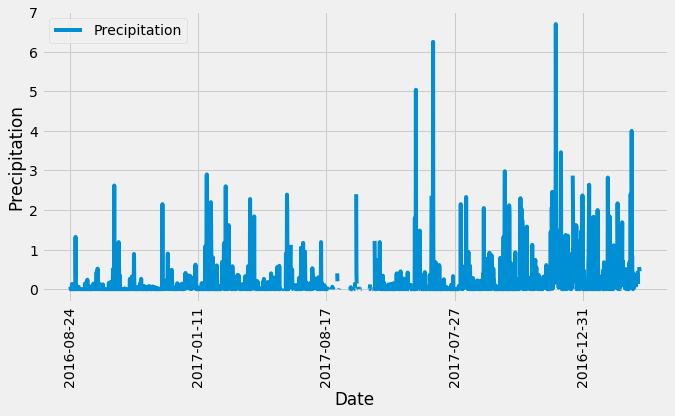

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_f = dt.datetime(int(split_date[0]),int(split_date[1]),int(split_date[2]))


# Calculate the date one year from the last date in data set.

date_i = dt.datetime(int(split_date[0])-1,int(split_date[1]),int(split_date[2]))




# List comprehension solution
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.id,Measurement.station, Measurement.date,Measurement.prcp,Measurement.tobs).\
                  filter(Measurement.date >= date_i).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
result_date = [result[2] for result in results]
result_pres = [result[3] for result in results]

dict_df = {
    'Date': result_date,
    'Precipitation': result_pres
}

precipitation_df = pd.DataFrame(dict_df)

precipitation_df.set_index('Date', inplace = True)
# Sort the dataframe by date
precipitation_df
# Use Pandas Plotting with Matplotlib to plot the data
#x_ticks []
precipitation_df.plot(kind='line', rot = '90',figsize=(10,5))
plt.ylabel('Precipitation')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
num_station = session.query(Measurement.station.distinct()).count()
num_station

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station,func.count(Measurement.station))\
.group_by(Measurement.station).order_by((func.count(Measurement.station).desc())).all()


(active_station)
#pd.read_sql_query(active_station,session.bind)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = active_station[0][0]


max_temp = session.query(Measurement.station,Measurement.date,func.max(Measurement.tobs))\
.filter(Measurement.station == most_active_id).all()

min_temp = session.query(Measurement.station,Measurement.date,func.min(Measurement.tobs))\
.filter(Measurement.station == most_active_id).all()

avg_temp = session.query(Measurement.station,Measurement.date,func.avg(Measurement.tobs))\
.filter(Measurement.station == most_active_id).all()

print(f'The highest temperatrue is {max_temp[0][2]}')
print(f'The lowest temperature is {min_temp[0][2]}')
print(f'The average tempeature is {avg_temp[0][2]}')

The highest temperatrue is 85.0
The lowest temperature is 54.0
The average tempeature is 71.66378066378067


Text(0.5, 0, 'Temperature')

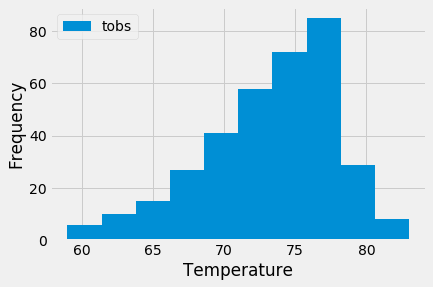

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#plot_temp = session.query(Measurement.station,Measurement.date,Measurement.tobs)\
plot_temp = session.query(Measurement.tobs)\
.filter(Measurement.station == most_active_id)\
.filter(Measurement.date.between(date_i,date_f)).all()
plot_df = pd.DataFrame(plot_temp)
plot_df.plot(kind = 'hist')
plt.xlabel('Temperature')

# Close session

In [20]:
# Close Session
session.close()